In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

In [35]:
# load data
df = pd.read_csv("iris_synthetic_data.csv")
df.head()


,sepal length,sepal width,petal length,petal width,label
0,5.2,3.8,1.5,0.3,Iris-setosa
1,5.3,4.1,1.5,0.1,Iris-setosa
2,4.8,3.1,1.5,0.2,Iris-setosa
3,5.2,3.7,1.5,0.2,Iris-setosa
4,4.9,3.0,1.5,0.3,Iris-setosa


In [36]:
print(df["label"].value_counts())

label
Iris-setosa        1000
Iris-versicolor    1000
Iris-virginica     1000
Name: count, dtype: int64


In [37]:
# df_binary = df[df["label"].isin(["Iris-setosa", "Iris-virginica"])].copy()
df_binary = df[df["label"].isin(["Iris-versicolor", "Iris-virginica"])].copy()

print(df_binary["label"].value_counts())

label
Iris-versicolor    1000
Iris-virginica     1000
Name: count, dtype: int64


In [38]:
# df_binary["label"] = df_binary["label"].map({"Iris-setosa": 0, "Iris-virginica": 1})
df_binary["label"] = df_binary["label"].map({"Iris-versicolor": 0, "Iris-virginica": 1})

In [39]:
# manual-normalize min-max
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

X = df_binary.drop("label", axis=1)
X = normalize(X).values
# numpy array
y = df_binary["label"].values.reshape(-1, 1)
# X = normalize(pd.DataFrame(X)).values
# print(X)

In [40]:
# train_test_split
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    test_count = int(X.shape[0] * test_size)
    train_index = indices[:-test_count]
    test_index = indices[-test_count:]

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))

1600


In [41]:
class LogictisRegression:
    def __init__(self, learning_rate=0.01, iterations=2000, convergence_tol=1e-6, batch_size=None):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.convergence_tol = convergence_tol
        self.batch_size = batch_size
        self.w = None
        self.b = None
        self.losses = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, y_true, y_pred):
        e = 1e-8
        return -np.mean(y_true * np.log(y_pred + e) + (1 - y_true) * np.log(1 - y_pred + e))

    def fit(self, X, y):
        self.w = np.zeros((X.shape[1], 1))
        self.b = 0

        for iters in range(self.iterations):
            # shuffle data every epoch for avoiding batch deviation
            idx = np.random.permutation(X.shape[0])
            X_shuffled = X[idx]
            y_shuffled = y[idx]

            batch_size = self.batch_size or X.shape[0]
            num_batches = int(np.ceil(X.shape[0] / batch_size))

            # y_pred = self.predict(X)
            # error = y_pred - y
            # loss = self.compute_loss(y, y_pred)
            # self.losses.append(loss)

            for batch in range(num_batches):
                start = batch * batch_size
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = self.sigmoid(X_batch @ self.w + self.b)
                error = y_pred - y_batch

                dw = X_batch.T @ error / X_batch.shape[0]
                db = np.mean(error)

                self.w -= self.learning_rate * dw
                self.b -= self.learning_rate * db

            y_pred_all = self.sigmoid(X @ self.w + self.b)
            loss = self.compute_loss(y, y_pred_all)
            self.losses.append(loss)

            if iters > 0 and abs(self.losses[-1] - self.losses[-2]) < self.convergence_tol:
                break

            # dw = X.T @ error / X.shape[0]
            # db = np.mean(error)

            # self.w -= self.learning_rate * dw
            # self.b -= self.learning_rate * db

    def predict(self, X):
        z = X @ self.w + self.b
        return self.sigmoid(z)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_true = (y_pred >= 0.5).astype(int)
        accuracy = (y_true == y).mean()
        return accuracy

In [45]:
batch_sizes = [16, 32, 64]

print("Classification Between Versicolor and Virginica")
for batch_size in batch_sizes:
    model = LogictisRegression(learning_rate=0.1, iterations=1000, convergence_tol=1e-6, batch_size=batch_size)
    model.fit(X_train, y_train)
    
    acc_train = model.evaluate(X_train, y_train)
    acc_test = model.evaluate(X_test, y_test)

    print(f"Batch Size = {batch_size}:" )
    print(f"Train Acc: {acc_train:.4f}")
    print(f"Test Acc: {acc_test:.4f}")
    print("\n")



Classification Between Versicolor and Virginica
Batch Size = 16:
Train Acc: 0.9825
Test Acc: 0.9950


Batch Size = 32:
Train Acc: 0.9825
Test Acc: 0.9950


Batch Size = 64:
Train Acc: 0.9775
Test Acc: 0.9875




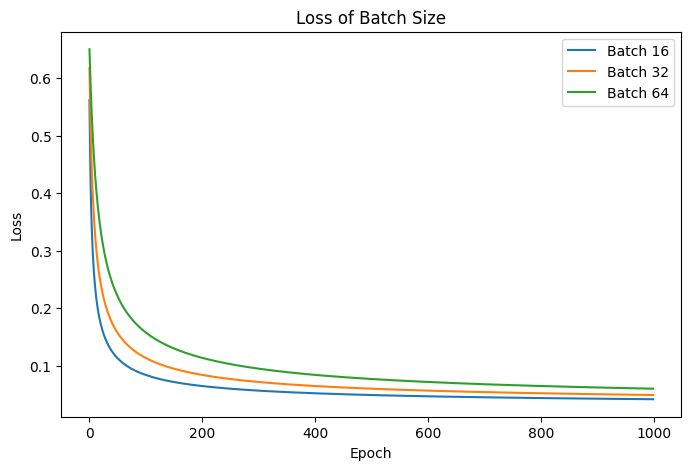

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for batch_size in batch_sizes:
    model = LogisticRegression(learning_rate=0.1, iterations=1000, convergence_tol=1e-6, batch_size=batch_size)
    model.fit(X_train, y_train)
    plt.plot(model.losses, label=f"Batch {batch_size}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss of Batch Size")
plt.legend()
plt.show()
